# Lab | Making predictions with logistic regression

In [135]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import getpass 
password = getpass.getpass()

In [136]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)

## 1. Create a query or queries to extract the information you think may be relevant for building the prediction model. It should include some film features and some rental features (X).

In [137]:
query = '''SELECT film.title, film.rental_rate, film.length, film.rating, category.name 
FROM sakila.film
JOIN sakila.film_category
ON film.film_id = film_category.film_id
JOIN sakila.category
ON film_category.category_id = category.category_id;'''

film_rental_data = pd.read_sql_query(query, engine)
display(film_rental_data.shape)
display(film_rental_data.head())

(1000, 5)

,title,rental_rate,length,rating,name
0,AMADEUS HOLY,0.99,113,PG,Action
1,AMERICAN CIRCUS,4.99,129,R,Action
2,ANTITRUST TOMATOES,2.99,168,NC-17,Action
3,ARK RIDGEMONT,0.99,68,NC-17,Action
4,BAREFOOT MANCHURIAN,2.99,129,G,Action


## 2. Create a query to get the list of all unique film titles and a boolean indicating if it was rented (rental_date) in May 2005. (Create new column called - 'rented_in_may'). This will be our TARGET (y) variable.

In [138]:
unique_films_query = '''with films_rented_may as (SELECT DISTINCT inventory.film_id FROM sakila.inventory
JOIN sakila.rental
ON inventory.inventory_id = rental.inventory_id
WHERE MONTH(rental.rental_date) =5 AND YEAR(RENTAL.rental_date)=2005) 
SELECT film.title, film.rental_rate, film.length, film.rating, category.name, 
CASE 
	WHEN films_rented_may.film_id is not null THEN 1 
    ELSE 0 
END AS 'rented_in_may'
FROM sakila.film
left join films_rented_may on films_rented_may.film_id = film.film_id
JOIN sakila.film_category
ON film.film_id = film_category.film_id
JOIN sakila.category
ON film_category.category_id = category.category_id;'''

## 3. Read the data into a Pandas dataframe. At this point you should have 1000 rows. Number of columns depends on the number of features you chose.


In [139]:
unique_films_may = pd.read_sql_query(unique_films_query, engine)
display(unique_films_may.shape)
display(unique_films_may)

(1000, 6)

,title,rental_rate,length,rating,name,rented_in_may
0,AMADEUS HOLY,0.99,113,PG,Action,1
1,AMERICAN CIRCUS,4.99,129,R,Action,1
2,ANTITRUST TOMATOES,2.99,168,NC-17,Action,1
3,ARK RIDGEMONT,0.99,68,NC-17,Action,0
4,BAREFOOT MANCHURIAN,2.99,129,G,Action,1
...,...,...,...,...,...,...
995,VALENTINE VANISHING,0.99,48,PG-13,Travel,1
996,WINDOW SIDE,2.99,85,R,Travel,0
997,WOLVES DESIRE,0.99,55,NC-17,Travel,0
998,WORKER TARZAN,2.99,139,R,Travel,0


## 4. Analyze extracted features (X) and transform them. You may need to encode some categorical variables, or scale numerical variables.


In [140]:
unique_films_may.dtypes

title             object
rental_rate      float64
length             int64
rating            object
name              object
rented_in_may      int64
dtype: object

In [141]:
unique_films_may['rented_in_may'] = unique_films_may['rented_in_may'].astype(bool)
unique_films_may.dtypes

title             object
rental_rate      float64
length             int64
rating            object
name              object
rented_in_may       bool
dtype: object

In [142]:
unique_films_may.isna().sum()

title            0
rental_rate      0
length           0
rating           0
name             0
rented_in_may    0
dtype: int64

### Numerical columns

C:\Users\laura\AppData\Local\Temp\ipykernel_13512\993139466.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = unique_films_may.corr()


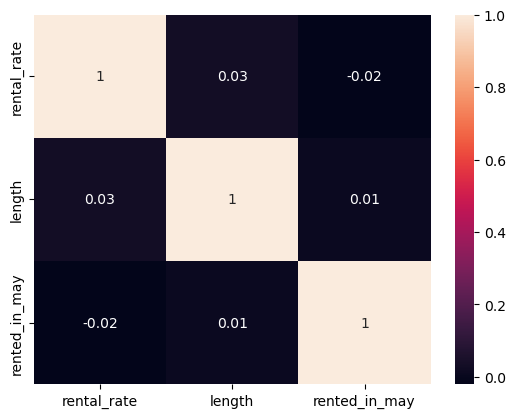

In [143]:
import seaborn as sns
import matplotlib.pyplot as plt
correlation_matrix = unique_films_may.corr()
sns.heatmap(correlation_matrix, annot=True)
plt.show()

The correlation matrix doesn't show any multicollinearity

In [144]:
unique_films_may.describe().T

,count,mean,std,min,25%,50%,75%,max
rental_rate,1000.0,2.980,1.646393,0.99,0.99,2.99,4.99,4.99
length,1000.0,115.272,40.426332,46.00,80.00,114.00,149.25,185.00


In [145]:
unique_films_may[['rental_rate','length']].skew()

rental_rate    0.009268
length         0.033321
dtype: float64

There will be no need to do a transformation, but scaling will be necessary

In [146]:
unique_films_may['rental_rate'].unique()

array([0.99, 4.99, 2.99])

There are only 3 values in the column rental_rate. It will be treated as categorical

In [147]:
unique_films_may['rental_rate'] = unique_films_may['rental_rate'].astype('object')
unique_films_may.dtypes

title            object
rental_rate      object
length            int64
rating           object
name             object
rented_in_may      bool
dtype: object

In [148]:
y = unique_films_may['rented_in_may']
X = unique_films_may.drop('rented_in_may', axis=1)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

In [149]:
import numpy as np
X_train_num = X_train.select_dtypes(np.number)
X_test_num = X_test.select_dtypes(np.number)

X_train_cat = X_train.select_dtypes('object')
X_test_cat = X_test.select_dtypes('object')

In [150]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(X_train_num)

import os
import pickle

path = "scalers/"
isExist = os.path.exists(path)
if not isExist:
    os.makedirs(path)
    print("The new directory is created!")

filename = "min_max_scaler.pkl"
with open(path+filename, "wb") as file:
    pickle.dump(scaler, file)

X_train_num_scaled = scaler.transform(X_train_num)
X_test_num_scaled  = scaler.transform(X_test_num)

X_train_num_scaled_df = pd.DataFrame(X_train_num_scaled, columns=X_train_num.columns)
X_test_num_scaled_df  = pd.DataFrame(X_test_num_scaled,  columns=X_test_num.columns)

X_train_num_scaled_df.head()

,length
0,0.546763
1,0.309353
2,0.971223
3,0.043165
4,0.820144


In [151]:
X_train_num_scaled_df.describe().T

,count,mean,std,min,25%,50%,75%,max
length,800.0,0.494469,0.286932,0.0,0.244604,0.489209,0.726619,1.0


Drop the title column because all the values are different

In [152]:
X_train_cat = X_train_cat.drop(['title'],axis=1)
X_test_cat = X_test_cat.drop(['title'],axis=1)

In [153]:
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(drop='if_binary', sparse=False)

one_hot_encoder.fit(X_train_cat)

path = "encoders/"
isExist = os.path.exists(path)
if not isExist:
    os.makedirs(path)
    print("The new directory is created!")

filename = "one_hot_encoder.pkl" 
with open(path+filename, "wb") as file:
    pickle.dump(one_hot_encoder, file) 

X_train_cat_encoded = one_hot_encoder.transform(X_train_cat)
X_test_cat_encoded = one_hot_encoder.transform(X_test_cat)

X_train_cat_encoded_df = pd.DataFrame(X_train_cat_encoded, 
                                          columns=one_hot_encoder.get_feature_names_out())
X_test_cat_encoded_df = pd.DataFrame(X_test_cat_encoded, 
                                         columns=one_hot_encoder.get_feature_names_out())
X_train_cat_encoded_df.head()

c:\Users\laura\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,rental_rate_0.99,rental_rate_2.99,rental_rate_4.99,rating_G,rating_NC-17,rating_PG,rating_PG-13,rating_R,name_Action,name_Animation,...,name_Drama,name_Family,name_Foreign,name_Games,name_Horror,name_Music,name_New,name_Sci-Fi,name_Sports,name_Travel
0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [154]:
X_train_transformed = pd.concat([X_train_num_scaled_df,X_train_cat_encoded_df],axis=1)
X_train_transformed

,length,rental_rate_0.99,rental_rate_2.99,rental_rate_4.99,rating_G,rating_NC-17,rating_PG,rating_PG-13,rating_R,name_Action,...,name_Drama,name_Family,name_Foreign,name_Games,name_Horror,name_Music,name_New,name_Sci-Fi,name_Sports,name_Travel
0,0.546763,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.309353,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.971223,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.043165,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.820144,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,0.424460,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
796,0.388489,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
797,0.136691,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
798,0.633094,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [155]:
X_test_transformed = pd.concat([X_test_num_scaled_df,X_test_cat_encoded_df],axis=1)
X_test_transformed

,length,rental_rate_0.99,rental_rate_2.99,rental_rate_4.99,rating_G,rating_NC-17,rating_PG,rating_PG-13,rating_R,name_Action,...,name_Drama,name_Family,name_Foreign,name_Games,name_Horror,name_Music,name_New,name_Sci-Fi,name_Sports,name_Travel
0,0.841727,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.122302,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.028777,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.812950,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.597122,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.978417,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
196,0.920863,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
197,0.093525,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
198,0.575540,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 5. Create a logistic regression model to predict 'rented_in_may' from the cleaned data.

In [156]:
from sklearn.linear_model import LogisticRegression

classification = LogisticRegression(random_state=0, solver='lbfgs',
                  multi_class='multinomial')

classification.fit(X_train_transformed, y_train)

LogisticRegression(multi_class='multinomial', random_state=0)

In [157]:
y_test_pred = classification.predict(X_test_transformed)
print(y_test_pred)

from sklearn.metrics import accuracy_score

print(accuracy_score(y_test,y_test_pred))
classification.score(X_test_transformed, y_test)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True False  True  True  True  True
  True  True  True  True  True False False  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True False  True  True False  True  True  True  True  True  True
  True  True False  True  True  True False  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
 False  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True False  True  True False  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True False  True False  True  T

0.69

## 6. Evaluate the results.

In [158]:
y_test.value_counts()

True     142
False     58
Name: rented_in_may, dtype: int64

In [159]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
confusion_matrix(y_test, y_test_pred)

array([[  4,  54],
       [  8, 134]], dtype=int64)

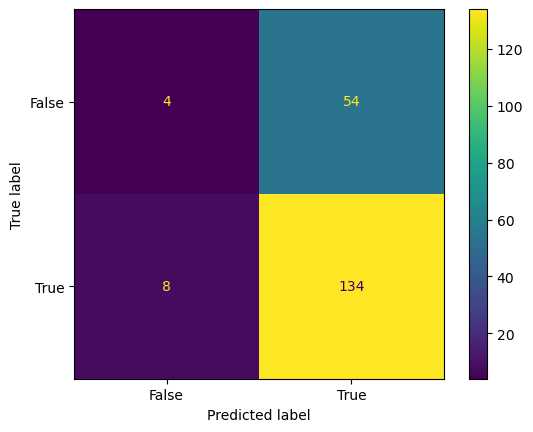

In [160]:
cm_test = confusion_matrix(y_test, y_test_pred)

disp = ConfusionMatrixDisplay(cm_test,display_labels=classification.classes_)
disp.plot()
plt.show()

In [161]:
from sklearn.metrics import cohen_kappa_score
cohen_kappa_score(y_test, y_test_pred)

0.016497461928934087

In [162]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

       False       0.33      0.07      0.11        58
        True       0.71      0.94      0.81       142

    accuracy                           0.69       200
   macro avg       0.52      0.51      0.46       200
weighted avg       0.60      0.69      0.61       200



The Cohen's Kappa indicates slight agreement. This means that this logistic regression model predicts labels that have limited agreement with the true labels.